In [ ]:
#Загрузка файла с табличными данными
!wget https://www.dropbox.com/s/2yjaru8mbkeynwe/dataset%20%283%29.csv?dl=1 -O dataset.csv

In [1]:
#Импортирование необходимых библиотек для обработки и чтение файла с табличными данными
import cv2
import os
import numpy as np
import shutil
import torch
import zipfile
import cv2
import os
import numpy as np
import pandas as pd
import datetime as dt
dataset = pd.read_csv('dataset.csv')

In [2]:
dataset.columns

Index(['video_id', 'video_duration', 'video_title', 'review', 'video',
       'channel_founded', 'published_at', 'subcriber_count', 'view_count',
       'like_count', 'dislike_count', 'favorite_count', 'comment_count',
       'data_published_at_last_video', 'title_last_video', 'view_count_new'],
      dtype='object')

In [3]:
#Обработка временных показателей даты загрузки видео на видеохостинг и даты создания канала.
dataset['Time_cur'] = pd.to_datetime(dataset['published_at'])
dataset['published_hour_cur'] = dataset['Time_cur'].dt.hour
dataset['Weekday_cur'] = dataset['Time_cur'].dt.weekday
diff = dt.datetime.now() - dataset['Time_cur']
dataset['Published_cur_time'] = (dt.datetime.now() - dataset['Time_cur']).dt.total_seconds()
dataset  = dataset.drop(['Time_cur', 'published_at'], axis=1)
dataset['channel_founded'] = pd.to_datetime(dataset['channel_founded'])
diff = dt.datetime.now() - dataset['channel_founded']
dataset['channel_founded'] = diff.dt.total_seconds()

In [4]:
# Деление видео на классы популярных и непопулярных
dataset['popular'] = 0.0
dataset['popular'][dataset.view_count_new.gt(dataset.view_count_new.quantile(0.8))] = 1.0

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# Обработка категориальных признаков(день недели и час публикации видео) при помощи one hot encoder.
from sklearn.preprocessing import OneHotEncoder
dataset = pd.get_dummies(dataset, columns=['published_hour_cur', 'Weekday_cur'], prefix=["published_hour", "Weekday_cur"] )

In [6]:
# Приминение нормализации к вещественным признакам, которые используются для классификации видео.
from sklearn.preprocessing import StandardScaler
dataset_norm = dataset[['channel_founded', 'subcriber_count', 'view_count', 'like_count', 'dislike_count', 'favorite_count', 'comment_count',  'Published_cur_time' ]]
dataset_norm  = dataset_norm.values
scaler = StandardScaler()
dataset_norm = scaler.fit_transform(dataset_norm)
dataset[['channel_founded', 'subcriber_count', 'view_count', 'like_count', 'dislike_count', 'favorite_count', 'comment_count',  'Published_cur_time' ]] = dataset_norm 







In [7]:
#Разбиение набора данных на обучающую, валидационную и тестовую выборку по времени публикации видео.

In [8]:
train_ids = int(0.8*len(dataset))
val_ids = int(0.8*len(dataset)) + int(0.1*len(dataset))
train = dataset[:train_ids]
val = dataset[train_ids:val_ids]
test = dataset[val_ids:len(dataset)]

In [9]:
!pip install xgboost

In [10]:
train_numerical = train[['channel_founded', 'subcriber_count', 'view_count', 'like_count','dislike_count', 'comment_count', 'Published_cur_time']]
train_categorical = train[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']]
train_target = train[['popular']]

In [11]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count', 'like_count','dislike_count', 'comment_count', 'Published_cur_time']]
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']]
val_target = val[['popular']].values

In [12]:
test_numerical = val[['channel_founded', 'subcriber_count', 'view_count', 'like_count','dislike_count', 'comment_count', 'Published_cur_time']]
test_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']]
test_target = val[['popular']].values

In [14]:
train_numerical = train_numerical.rename(columns={"view_count": "view_count_prev", "like_count": "like_count_prev", "dislike_count":"dislike_count_prev", "comment_count":"comment_count_prev" })

In [15]:
val_numerical = val_numerical.rename(columns={"view_count": "view_count_prev", "like_count": "like_count_prev", "dislike_count":"dislike_count_prev", "comment_count":"comment_count_prev" })

In [16]:
test_numerical = test_numerical.rename(columns={"view_count": "view_count_prev", "like_count": "like_count_prev", "dislike_count":"dislike_count_prev", "comment_count":"comment_count_prev" })

In [17]:
train_boost = [train_numerical, train_categorical]
train_boost = pd.concat(train_boost, axis = 1)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
clf =  GradientBoostingClassifier(random_state=0)
clf.fit(train_boost, train_target.values.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
val_boost = [val_numerical, val_categorical]
val_boost = pd.concat(val_boost, axis = 1)

In [20]:
feature_importance = clf.feature_importances_

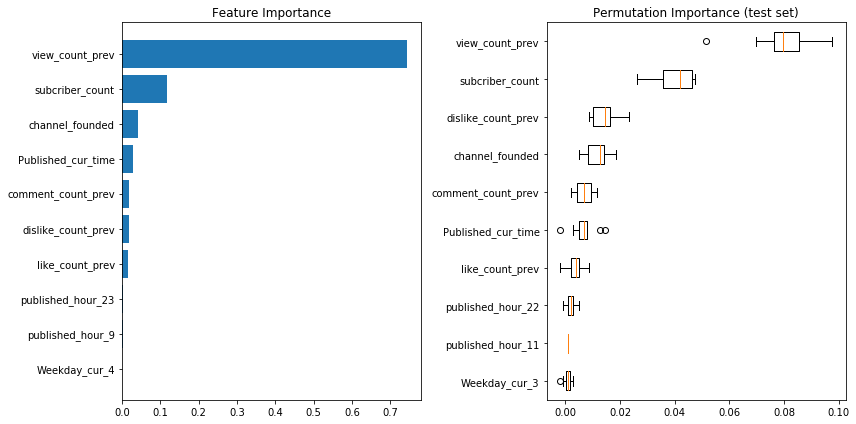

In [22]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(train_boost.columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(val_boost.columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [23]:
res = clf.predict_proba(val_boost)

In [24]:
res = res[:,1]

# Gradboost experiments

In [27]:
test_boost = [test_numerical, test_categorical]
test_boost = pd.concat(test_boost, axis = 1)

In [28]:
#lr = 0.1
#n_est = 100
#max_depth = 3
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
clf.fit(train_boost, train_target.values.ravel())


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
res = clf.predict_proba(val_boost)

In [30]:
def binary_acc(y_pred, y_test, thresh):
    y_pred_tag = (y_pred>thresh).astype(int)
    print(y_pred_tag.shape, y_test.shape)
    correct_results_sum = (y_pred_tag == y_test.squeeze()).sum()
    print(correct_results_sum)
    acc = correct_results_sum/y_test.shape[0]
    acc = acc.item()
    return acc

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [32]:
print(prec)
print(rec)
print(roc_auc)

0.645
0.5443037974683544
0.7276098661118434


In [33]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

(1034,) (1034,)
855
0.8268858800773694


In [34]:
res = clf.predict_proba(test_boost)

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [36]:
print(prec)
print(rec)
print(roc_auc)

0.645
0.5443037974683544
0.7276098661118434


In [37]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

(1034,) (1034,)
855
0.8268858800773694


In [38]:
#lr = 0.1
#n_est = 1000
#max_depth = 3
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=3)
clf.fit(train_boost, train_target.values.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
res = clf.predict_proba(val_boost)

In [40]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [41]:
print(prec)
print(rec)
print(roc_auc)

0.6
0.5569620253164557
0.7232739863094199


In [42]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

(1034,) (1034,)
841
0.8133462282398453


In [43]:
res = clf.predict_proba(test_boost)

In [44]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))


In [45]:
print(prec)
print(rec)
print(roc_auc)

0.6
0.5569620253164557
0.7232739863094199


In [46]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

(1034,) (1034,)
841
0.8133462282398453


In [ ]:
#lr = 0.1
#n_est = 100
#max_depth = 3
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=10000, max_depth=3)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)

In [ ]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)

In [ ]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, max_depth=3)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)

In [ ]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)

In [ ]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.001, n_estimators=100, max_depth=3)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)

In [ ]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)

In [ ]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=4)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)

In [ ]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)

In [ ]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=1)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)

In [ ]:
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)

In [ ]:
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=2)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.01, n_estimators=10000, max_depth=1)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))

In [ ]:
clf =  GradientBoostingClassifier(learning_rate=0.01, n_estimators=10000, max_depth=2)
clf.fit(train_boost, train_target.values.ravel())

In [ ]:
res = clf.predict_proba(val_boost)
prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5))

In [ ]:
res = clf.predict_proba(test_boost)
prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))

In [ ]:
print(prec)
print(rec)
print(roc_auc)

In [ ]:
print(binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5))